In [ ]:
 import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import matplotlib.pyplot as plt
import torchvision.models as models



In [ ]:
def load_and_preprocess_data(batch_size=32):

    transform = transforms.Compose([
    transforms.Resize((32, 32)),transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

    # Load training and testing datasets
    trainset = torchvision.datasets.GTSRB(root='./data', split='train',
                                            download=True, transform=transform)
    testset = torchvision.datasets.GTSRB(root='./data', split='test',
                                           download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [ ]:
def visualize_data(trainloader, num_images=6):
    """
    Visualize a subset of images from the training dataset.

    Args:
        trainloader (DataLoader): The DataLoader object for the training dataset.
        num_images (int): The number of images to visualize.

    Returns:
        None
    """
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Show images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Unnormalize the image
        image = images[i] / 2 + 0.5
        npimg = image.cpu().numpy()

        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:



class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.layer_1 = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3,padding=1)
          ,nn.BatchNorm2d(32),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer_2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3))
        self.layer_4 = nn.Sequential(
         nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x




In [ ]:
class ResNet50(nn.Module):
    # used chatgpt to assist in ResNet50
    def __init__(self, num_classes=43):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)  # Load pretrained ResNet50
        for param in self.resnet50.parameters():
            param.requires_grad = False

        # Unfreeze the last two layers (layer4 and fc)
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True

        # Replace the fully connected layer
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [ ]:
class VGG16(nn.Module):
  #used chatgpt to assist in vgg16
    def __init__(self, num_classes=43):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)  # Load pretrained ResNet50
        for param in self.vgg16.parameters():
            param.requires_grad = False  # Freeze all by default

        # Unfreeze the last two layers (assuming they are classifier[5] and classifier[6])
        for param in self.vgg16.classifier[5].parameters():
            param.requires_grad = True
        for param in self.vgg16.classifier[6].parameters():
            param.requires_grad = True

        # Replace the classifier layer
        num_ftrs = self.vgg16.classifier[6].in_features  # Get input features of last layer
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x


In [ ]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=10):

    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0
      for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        predictions=torch.argmax(outputs,dim=-1)
        total+=labels.size(0)
        correct+=(predictions==labels).sum().item()
        optimizer.step()

      train_losses.append(running_loss / len(trainloader))
      train_accuracies.append(100 * correct / total)
      print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Epochs vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Epochs vs Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies








In [ ]:
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    loss=0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
      for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    loss /= len(testloader) #average loss

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {loss:.4f}")

    return accuracy, loss

In [ ]:
def visualize_predictions(model, testloader, device):
    """
    Visualize model predictions on a subset of the test dataset.

    Args:
        model (nn.Module): The trained CNN model.
        testloader (DataLoader): DataLoader for the test dataset.

    Returns:
        None
    """
    # used chatgpt to assist in modeling predictions on test dataset

    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Display images with predicted and actual labels
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i in range(5):
        # Unnormalize the image
        image = images[i] / 2 + 0.5
        npimg = image.cpu().numpy()

        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(f"Predicted: {predicted[i].item()}\nActual: {labels[i].item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

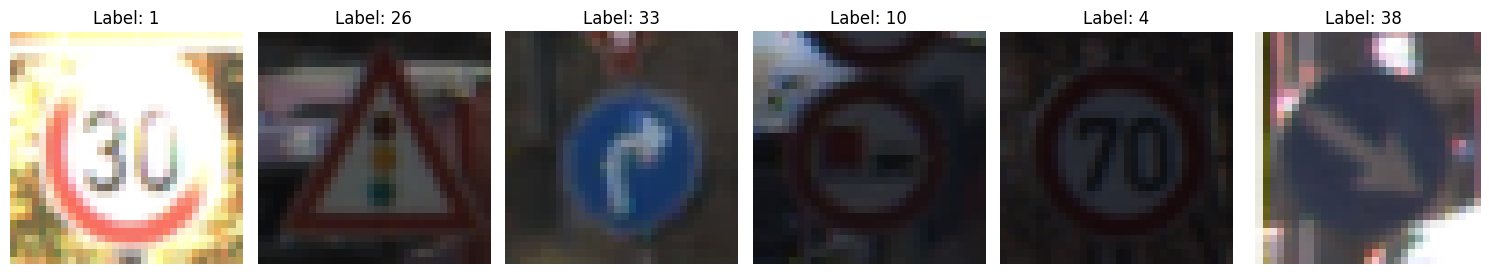

Epoch 1/10, Loss: 0.9182, Accuracy: 72.88%
Epoch 2/10, Loss: 0.1840, Accuracy: 94.29%
Epoch 3/10, Loss: 0.1075, Accuracy: 96.69%
Epoch 4/10, Loss: 0.0835, Accuracy: 97.48%
Epoch 5/10, Loss: 0.0648, Accuracy: 97.98%
Epoch 6/10, Loss: 0.0503, Accuracy: 98.43%
Epoch 7/10, Loss: 0.0422, Accuracy: 98.65%
Epoch 8/10, Loss: 0.0362, Accuracy: 98.96%
Epoch 9/10, Loss: 0.0283, Accuracy: 99.16%
Epoch 10/10, Loss: 0.0315, Accuracy: 99.03%


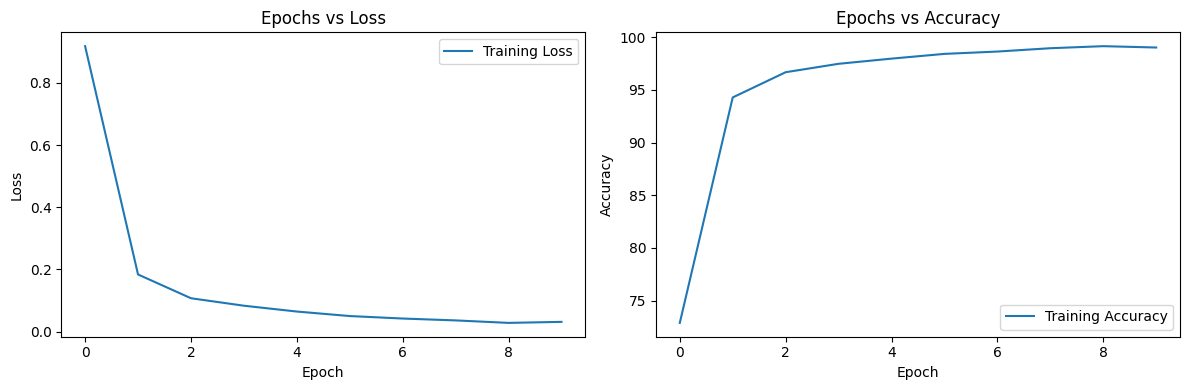

Test Accuracy: 93.56%
Test Loss: 0.2979


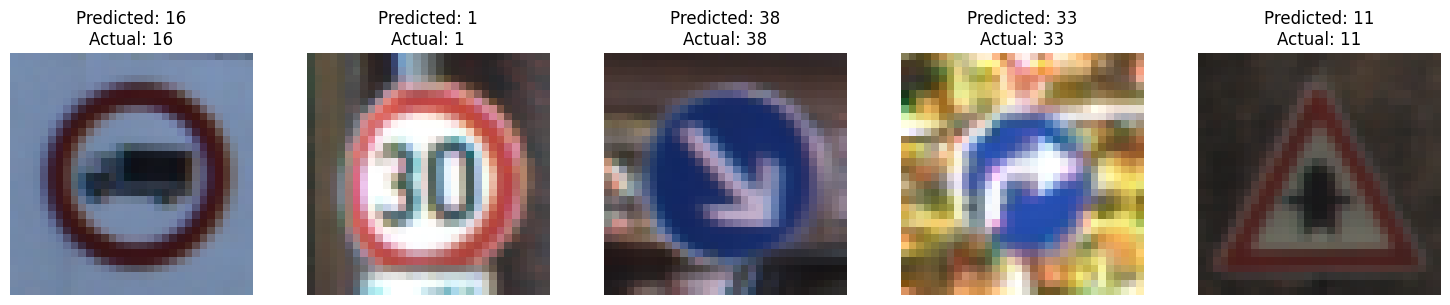

In [ ]:
def main():
    # Hyperparameters
    batch_size = 32              # Batch size for training
    learning_rate = 0.001        # Learning rate for optimizer
    epochs =10                 # Number of training epochs
    weight_decay = 1e-5
    torch.manual_seed(42)         # Weight decay (L2 regularization) to prevent overfitting

    # Check if GPU is available and use it
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    trainloader, testloader = load_and_preprocess_data(batch_size)

    # Visualize a subset of the data
    visualize_data(trainloader)

    # Initialize model, loss function, and optimizer
    model = TrafficSignCNN().to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, device, epochs=epochs)

    # Evaluate the model
    test_accuracy, test_loss = evaluate_model(model, testloader, device)

    # Visualize predictions
    visualize_predictions(model, testloader,device)

if __name__ == '__main__':
    main()


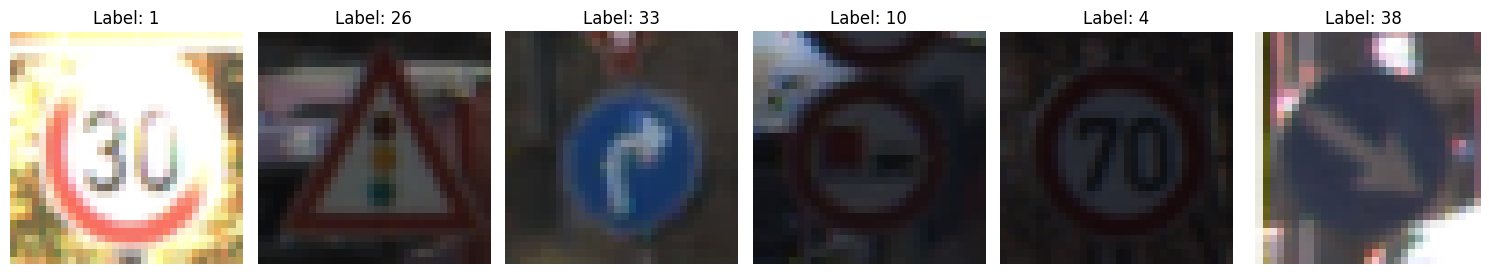

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Epoch 1/10, Loss: 0.9992, Accuracy: 70.31%
Epoch 2/10, Loss: 0.3309, Accuracy: 89.91%
Epoch 3/10, Loss: 0.2259, Accuracy: 93.10%
Epoch 4/10, Loss: 0.1511, Accuracy: 95.09%
Epoch 5/10, Loss: 0.1501, Accuracy: 95.32%
Epoch 6/10, Loss: 0.1406, Accuracy: 95.70%
Epoch 7/10, Loss: 0.1265, Accuracy: 96.35%
Epoch 8/10, Loss: 0.1178, Accuracy: 96.64%
Epoch 9/10, Loss: 0.0966, Accuracy: 97.02%
Epoch 10/10, Loss: 0.0756, Accuracy: 97.50%


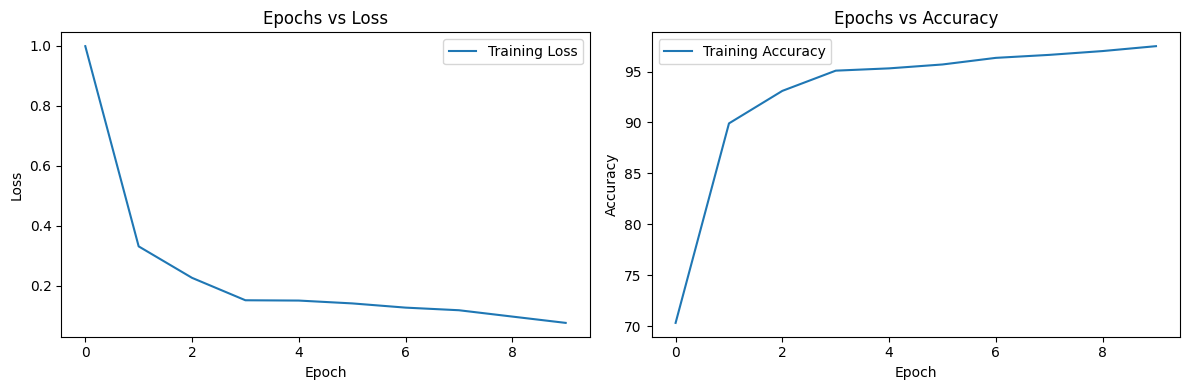

Test Accuracy: 65.64%
Test Loss: 1.8942


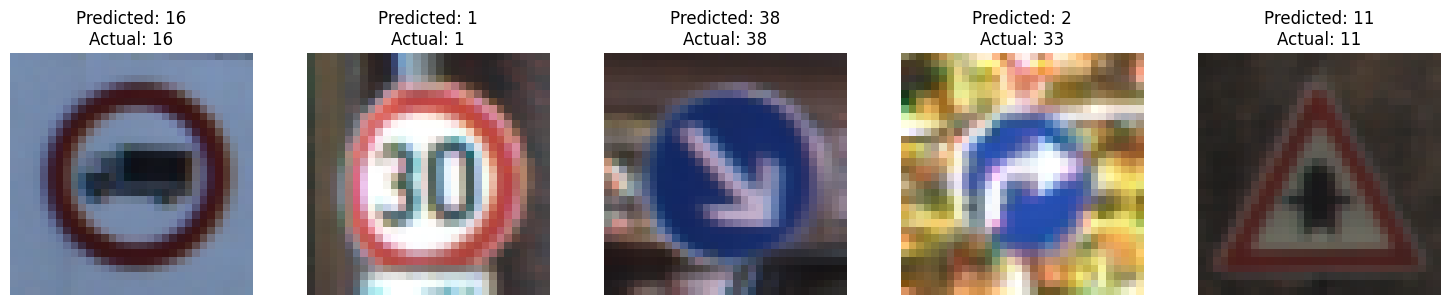

In [ ]:
def main():
    # Hyperparameters
    batch_size = 32              # Batch size for training
    learning_rate = 0.001        # Learning rate for optimizer
    epochs =10                 # Number of training epochs
    weight_decay = 1e-5
    torch.manual_seed(42)         # Weight decay (L2 regularization) to prevent overfitting

    # Check if GPU is available and use it
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    trainloader, testloader = load_and_preprocess_data(batch_size)

    # Visualize a subset of the data
    visualize_data(trainloader)

    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size expected by ResNet50 and VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize images using ImageNet statistics
])

    # Initialize model, loss function, and optimizer
    model = ResNet50().to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, device, epochs=epochs)

    # Evaluate the model
    test_accuracy, test_loss = evaluate_model(model, testloader, device)

    # Visualize predictions
    visualize_predictions(model, testloader,device)

if __name__ == '__main__':
    main()

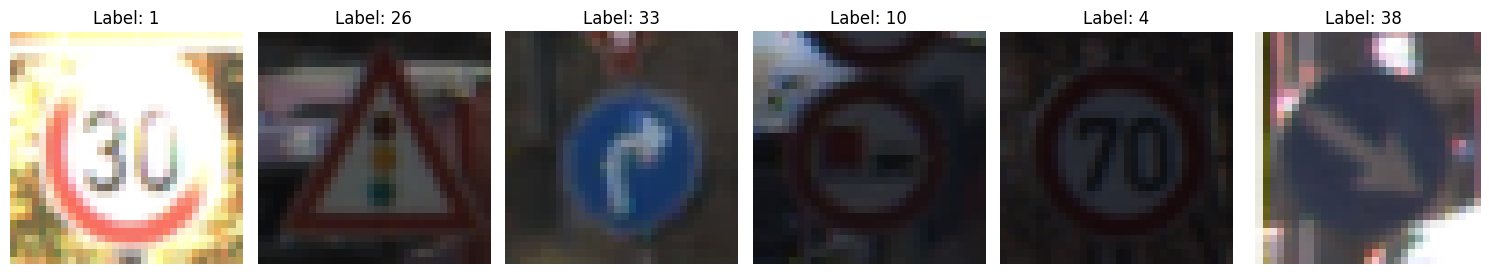

Epoch 1/10, Loss: 1.6168, Accuracy: 50.12%
Epoch 2/10, Loss: 1.1725, Accuracy: 61.46%
Epoch 3/10, Loss: 1.0768, Accuracy: 64.80%
Epoch 4/10, Loss: 1.0386, Accuracy: 66.13%
Epoch 5/10, Loss: 1.0166, Accuracy: 66.72%
Epoch 6/10, Loss: 0.9888, Accuracy: 67.67%
Epoch 7/10, Loss: 0.9707, Accuracy: 68.22%
Epoch 8/10, Loss: 0.9660, Accuracy: 68.41%
Epoch 9/10, Loss: 0.9470, Accuracy: 69.18%
Epoch 10/10, Loss: 0.9384, Accuracy: 69.80%


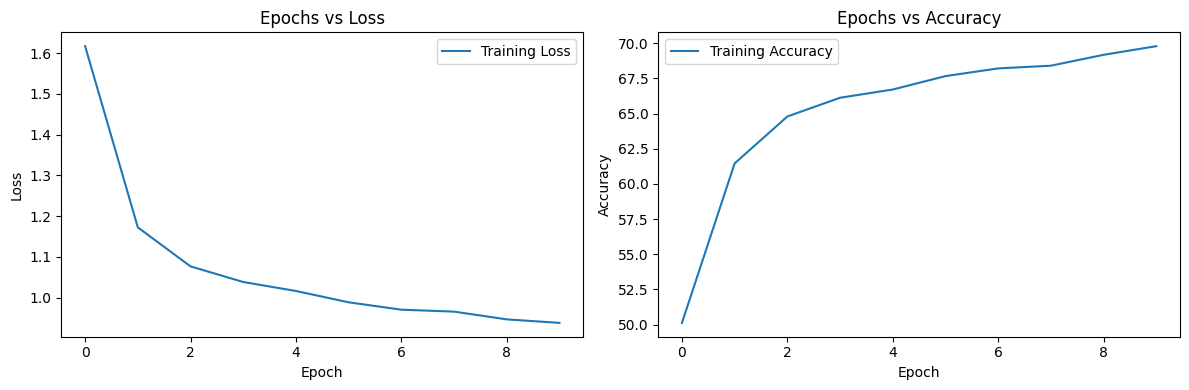

Test Accuracy: 45.40%
Test Loss: 2.4732


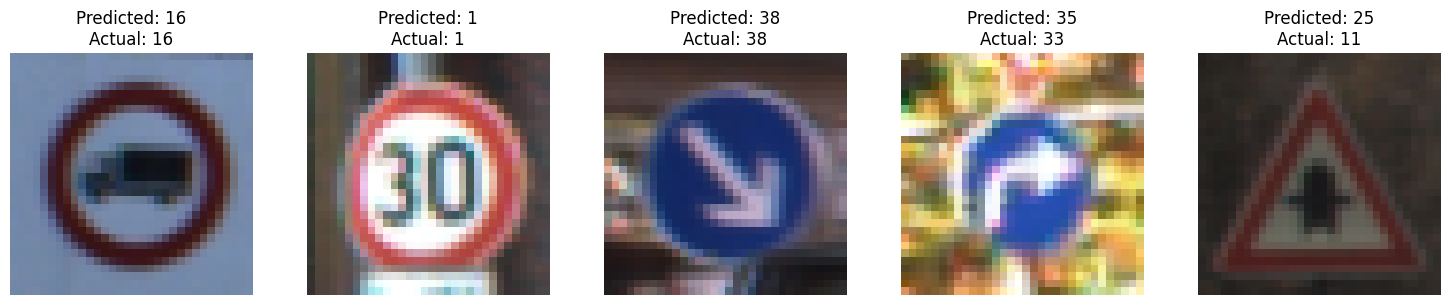

In [ ]:
def main():
    # Hyperparameters
    batch_size = 32              # Batch size for training
    learning_rate = 6e-4        # Learning rate for optimizer
    epochs =10                 # Number of training epochs
    weight_decay = 1e-5
    torch.manual_seed(42)         # Weight decay (L2 regularization) to prevent overfitting

    # Check if GPU is available and use it
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    trainloader, testloader = load_and_preprocess_data(batch_size)

    # Visualize a subset of the data
    visualize_data(trainloader)

    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size expected by ResNet50 and VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize images using ImageNet statistics
])


    # Initialize model, loss function, and optimizer
    model = VGG16().to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, device, epochs=epochs)

    # Evaluate the model
    test_accuracy, test_loss = evaluate_model(model, testloader, device)

    # Visualize predictions
    visualize_predictions(model, testloader,device)

if __name__ == '__main__':
    main()